In [ ]:
import numpy as np
import pandas as pd
from pandas import Series

import pathlib
from glob import glob
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization
from tensorflow.python.keras.models import Sequential, Model
from keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers
from keras.applications.xception import Xception
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, BackupAndRestore
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras import regularizers

In [ ]:
# Connecting to Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Intel_Images_Bicubic.zip

Streaming output truncated to the last 5000 lines.
  inflating: Intel Images Bicubic/train/mountain/12066.jpg  
  inflating: Intel Images Bicubic/train/mountain/8169.jpg  
  inflating: Intel Images Bicubic/train/mountain/9277.jpg  
  inflating: Intel Images Bicubic/train/mountain/14403.jpg  
  inflating: Intel Images Bicubic/train/mountain/18239.jpg  
  inflating: Intel Images Bicubic/train/mountain/14832.jpg  
  inflating: Intel Images Bicubic/train/mountain/2875.jpg  
  inflating: Intel Images Bicubic/train/mountain/5698.jpg  
  inflating: Intel Images Bicubic/train/mountain/6391.jpg  
  inflating: Intel Images Bicubic/train/mountain/4579.jpg  
  inflating: Intel Images Bicubic/train/mountain/11989.jpg  
  inflating: Intel Images Bicubic/train/mountain/13146.jpg  
  inflating: Intel Images Bicubic/train/mountain/8343.jpg  
  inflating: Intel Images Bicubic/train/mountain/10329.jpg  
  inflating: Intel Images Bicubic/train/mountain/11023.jpg  
  inflating: Intel Images Bicubic/train/m

In [ ]:
# Data paths in drive
src_path_train = "/content/Intel Images Bicubic/train"
src_path_test = "/content/Intel Images Bicubic/test"
src_path_val = "/content/Intel Images Bicubic/val"

# Initializing IDG instances for training and testing

train_IDG = ImageDataGenerator(rescale=1./255,
    rotation_range=2,
    zoom_range=0.1,
    horizontal_flip=True)

test_IDG = ImageDataGenerator(rescale= 1./255.0)

In [ ]:
batch_size = 64
train_generator = train_IDG.flow_from_directory(
    src_path_train,
    target_size=(38,38),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    seed=42)

validation_generator = train_IDG.flow_from_directory(
    src_path_val, 
    target_size=(38,38),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    seed=42)

test_generator = test_IDG.flow_from_directory(
    src_path_test,
    target_size=(38,38),
    color_mode='rgb',
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    seed = 42)

Found 11224 images belonging to 6 classes.
Found 2810 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [123]:
model = VGG19(include_top = False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(38, 38, 3),
    pooling="max",
    classes=6,
    classifier_activation="softmax")

model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 38, 38, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 38, 38, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 38, 38, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 19, 19, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 19, 19, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 19, 19, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 9, 9, 128)         0     

In [124]:
from keras import Sequential

for layer in model.layers:
  layer.trainable = False

model_2=Sequential()
#Add the Dense layers along with activation and batch normalization
model_2.add(model)
model_2.add(Flatten())


#Add the Dense layers along with activation and batch normalization
model_2.add(Dense(1024,activation=('relu')))
model_2.add(Dense(1024,activation=('relu')))
# model_2.add(Dropout(.4, seed=42))
model_2.add(Dense(512,activation=('relu'))) 

# model_2.add(Dense(2048,activation=('relu'), kernel_regularizer=regularizers.L2(l2=0.01))) 
# model_2.add(Dropout(.3, seed=42))#Adding a dropout layer that will randomly drop 50% of the weights
# model_2.add(Dense(1024,activation=('relu'), kernel_regularizer=regularizers.L2(l2=0.01)))
# model_2.add(Dropout(.2, seed=42))
model_2.add(Dense(6,activation=('softmax'))) #This is the classification layer

In [125]:
model_2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_12 (Flatten)        (None, 512)               0         
                                                                 
 dense_48 (Dense)            (None, 1024)              525312    
                                                                 
 dense_49 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_50 (Dense)            (None, 512)               524800    
                                                                 
 dense_51 (Dense)            (None, 6)                 3078      
                                                                 
Total params: 22,127,174
Trainable params: 2,102,790


In [126]:
from keras.optimizers import SGD,Adam
# from tensorflow.keras.optimizers.legacy import SGD
learn_rate=.01

sgd = tf.keras.optimizers.legacy.SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam = Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [127]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=7, monitor='val_accuracy', restore_best_weights=True)

In [128]:
model_2.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [129]:
history = model_2.fit_generator(
              train_generator,
              steps_per_epoch = train_generator.samples // batch_size,
              validation_data = validation_generator, 
              validation_steps = validation_generator.samples // batch_size,
              callbacks=[learning_rate_reduction, early_stopping_monitor],
              epochs = 35,
              shuffle = True)

Epoch 1/35


<ipython-input-129-e2a20c532986>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_2.fit_generator(


175/175 [==============================] - 21s 115ms/step - loss: 1.0358 - accuracy: 0.5983 - val_loss: 0.8749 - val_accuracy: 0.6606 - lr: 0.0100
Epoch 2/35
175/175 [==============================] - 19s 109ms/step - loss: 0.8394 - accuracy: 0.6734 - val_loss: 0.8735 - val_accuracy: 0.6577 - lr: 0.0100
Epoch 3/35
175/175 [==============================] - 22s 124ms/step - loss: 0.7894 - accuracy: 0.6978 - val_loss: 0.7851 - val_accuracy: 0.7024 - lr: 0.0100
Epoch 4/35
175/175 [==============================] - 19s 110ms/step - loss: 0.7775 - accuracy: 0.7013 - val_loss: 0.7892 - val_accuracy: 0.7071 - lr: 0.0100
Epoch 5/35
175/175 [==============================] - 20s 113ms/step - loss: 0.7512 - accuracy: 0.7098 - val_loss: 0.8029 - val_accuracy: 0.6879 - lr: 0.0100
Epoch 6/35
175/175 [==============================] - 19s 109ms/step - loss: 0.7302 - accuracy: 0.7226 - val_loss: 0.7862 - val_accuracy: 0.6915 - lr: 0.0100
Epoch 7/35
175/175 [==============================] - ETA: 0s -

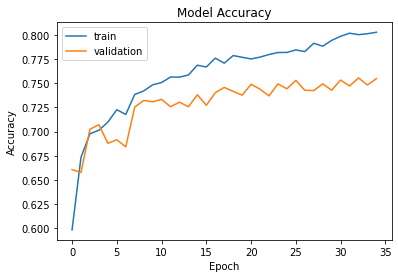

In [130]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

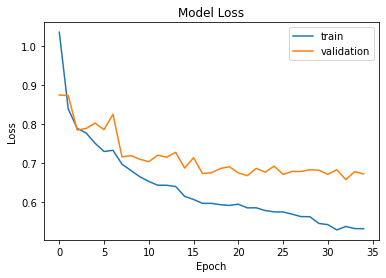

In [131]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [132]:
evaluate = model_2.evaluate(test_generator)
print(evaluate)

3000/3000 [==============================] - 25s 8ms/step - loss: 0.6590 - accuracy: 0.7627
[0.6589773893356323, 0.762666642665863]


In [133]:
print('The testing accuracy is :',evaluate[1]*100, '%')

The testing accuracy is : 76.2666642665863 %


In [134]:
model_2.save("vgg19_intel_bicubic.h5")